🎞️ Movie Project 📽️ 🎞️ - Data Analysis with IMDB database

__________
Importing packages
___

In [68]:
import re
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style= "whitegrid")

In [2]:
# !imdb-sqlite

In [3]:
# Connecting to database
conn = sqlite3.connect("imdb.db")

In [4]:
# List of tables
tabelas = pd.read_sql_query('''
                              SELECT NAME AS 'Table_Name' FROM sqlite_master
                              WHERE type = 'table'
                            ''',conn)


In [5]:
tabelas.head()

,Table_Name
0,people
1,titles
2,akas
3,crew
4,episodes


In [6]:
tabelas = tabelas["Table_Name"].values.tolist()

In [7]:
for tabela in tabelas:
    consulta = 'PRAGMA TABLE_INFO({})'.format(tabela)
    #"PRAGMA TABLE_INFO({'people'})" - return data from people table
    resultado = pd.read_sql_query(consulta,conn)
    print(f'Table schema: {tabela}')
    display(resultado)
    print('\n')

Table schema: people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0




Table schema: titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0




Table schema: akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0




Table schema: crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0




Table schema: episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0




Table schema: ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


___
1. Which are the most common movie categories on IMDB?
___

In [8]:
query1 = '''
        SELECT type, 
        COUNT(*) AS COUNT
        FROM titles
        GROUP BY type '''

In [9]:
result1 = pd.read_sql_query(query1,conn)
display(result1)

,type,COUNT
0,movie,617833
1,short,883060
2,tvEpisode,6876179
3,tvMiniSeries,44635
4,tvMovie,137122
5,tvPilot,2
6,tvSeries,229301
7,tvShort,10631
8,tvSpecial,37880
9,video,263953


In [10]:
result1['percentage'] = (result1['COUNT'] / result1['COUNT'].sum()) *100
display(result1)

,type,COUNT,percentage
0,movie,617833,6.765294
1,short,883060,9.669540
2,tvEpisode,6876179,75.294416
3,tvMiniSeries,44635,0.488755
4,tvMovie,137122,1.501491
5,tvPilot,2,0.000022
6,tvSeries,229301,2.510854
7,tvShort,10631,0.116410
8,tvSpecial,37880,0.414787
9,video,263953,2.890295


In [11]:
others = {}
others['COUNT'] = result1[result1['percentage'] < 5]['COUNT'].sum()
others['percentage'] = result1[result1['percentage'] < 5]['percentage'].sum()
others['type'] = 'others'

In [12]:
result1 = result1.loc[result1['percentage'] > 5]

In [13]:
result1 = result1.append(others, ignore_index = True)

In [14]:
result1 = result1.sort_values(by = 'COUNT', ascending = False).round(2)

In [15]:
result1

,type,COUNT,percentage
2,tvEpisode,6876179,75.29
1,short,883060,9.67
3,others,755317,8.27
0,movie,617833,6.77


In [16]:
labels = [str(result1['type'][i])+' '+'['+str(round(result1['percentage'][i],2)) +'%'+']' for i in result1.index]

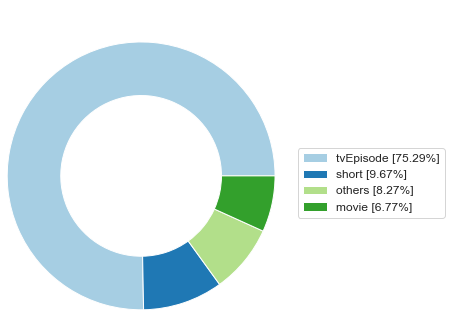

In [17]:
cs = cm.Paired(np.arange(2000))

figure = plt.figure(figsize=(3,4))

plt.pie(result1['COUNT'], labeldistance = 4, radius = 2, colors = cs, wedgeprops = dict(width = 0.8))
plt.legend(labels = labels, bbox_to_anchor = (1.4,0.7), prop = {'size':12})
plt.title("Category Distribution",color = 'white', pad = 70,fontfamily = 'Calibri', fontdict = {'fontsize':20,'fontweight':20})
plt.show()

_____
2. What's the title amount by genre?
___

In [18]:
query2 = '''
        SELECT genres, 
        COUNT(*) AS COUNT
        FROM titles
        WHERE type = 'movie'
        GROUP BY genres '''

In [19]:
result2 = pd.read_sql_query(query2,conn)
display(result2)

,genres,COUNT
0,Action,14140
1,"Action,Adult",11
2,"Action,Adult,Adventure",2
3,"Action,Adult,Comedy",6
4,"Action,Adult,Crime",9
...,...,...
1459,"Thriller,Western",43
1460,War,1311
1461,"War,Western",14
1462,Western,5083


In [20]:
# https://docs.python.org/3.8/library/re.html
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

def genre_return(df):
    df['genres'] = df['genres'].str.lower().values
    temp = df['genres'].dropna()
    pattern = '(?u)\\b[\\w-]+\\b'
    vector = CountVectorizer(token_pattern = pattern, analyzer = 'word').fit(temp)
    unique_genre =  vector.get_feature_names()
    unique_genre =  [genre for genre in unique_genre if len(genre) > 1]
    return unique_genre

In [21]:
def genre_return_matrix(df):
    df['genres'] = df['genres'].str.lower().values
    temp = df['genres'].dropna()
    pattern = '(?u)\\b[\\w-]+\\b'
    vector = CountVectorizer(token_pattern = pattern, analyzer = 'word').fit(temp)
    genre_pack = vector.transform(temp)
    unique_genre =  vector.get_feature_names()
    genres = pd.DataFrame(genre_pack.todense(), columns = unique_genre, index = temp.index)
    return genres

In [22]:
genres = genre_return_matrix(result2)

In [23]:
genres = genres.drop(columns = 'n', axis = 0)

In [24]:
genres_percentage = 100 * pd.Series(genres.sum()).sort_values(ascending = False) / genres.shape[0]
genres_percentage.index = genres_percentage.index.str.title()

In [25]:
genres_percentage.head(10)

Drama          17.964481
Comedy         17.008197
Documentary    15.846995
Adventure      14.822404
Action         14.480874
Romance        13.319672
Crime          13.046448
Mystery        12.431694
Thriller       12.295082
Horror         12.226776
dtype: float64

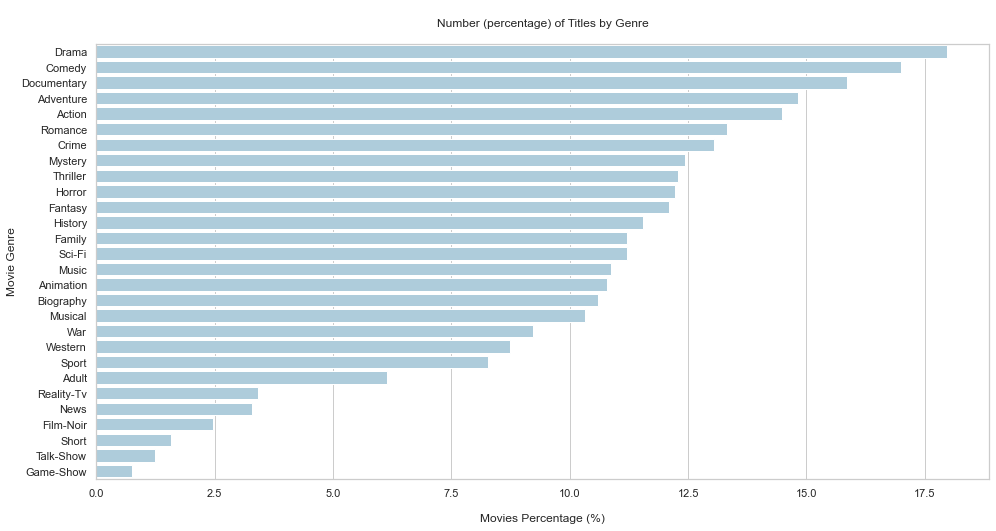

In [26]:
# Plot
plt.figure(figsize = (16,8))
sns.barplot(x = genres_percentage.values, y = genres_percentage.index, orient = "h", color = '#A6CEE3')
plt.ylabel('Movie Genre')             
plt.xlabel("\nMovies Percentage (%)")
plt.title('\nNumber (percentage) of Titles by Genre\n')
plt.show()

_____
3. What's the rating median of movies by genre?
___

In [27]:
query3 = '''
         SELECT rating, genres 
         FROM ratings
         JOIN titles ON ratings.title_id = titles.title_id
         WHERE premiered <= 2022 AND type = 'movie'
         '''

In [28]:
result3 = pd.read_sql_query(query3,conn)

In [29]:
display(result3)

,rating,genres
0,5.3,Romance
1,4.5,\N
2,6.0,"Action,Adventure,Biography"
3,4.7,Drama
4,4.5,Drama
...,...,...
280871,5.8,Thriller
280872,6.4,"Drama,History"
280873,3.8,"Adventure,History,War"
280874,8.3,Drama


In [30]:
unique_genre = genre_return(result3)

In [31]:
unique_genre

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [33]:
genre_counts = []
genre_ratings = []

for item in unique_genre:
    
    query = '''
               SELECT COUNT(rating) 
               FROM ratings 
               JOIN titles ON ratings.title_id=titles.title_id 
               WHERE genres LIKE '''+ '\''+'%'+item+'%'+'\' AND type=\'movie\''

         
    result = pd.read_sql_query(query, conn)
    genre_counts.append(result.values[0][0])
  
    query = '''
               SELECT rating 
               FROM ratings 
               JOIN titles ON ratings.title_id=titles.title_id 
               WHERE genres LIKE '''+ '\''+'%'+item+'%'+'\' AND type=\'movie\''

    result = pd.read_sql_query(query, conn)
    genre_ratings.append(np.median(result['rating']))

In [34]:
df_genre_ratings = pd.DataFrame()
df_genre_ratings['genres'] = unique_genre
df_genre_ratings['count'] = genre_counts
df_genre_ratings['rating'] = genre_ratings

In [35]:
df_genre_ratings.head(20)

,genres,count,rating
0,action,29170,5.80
1,adult,4398,5.80
2,adventure,17642,6.00
3,animation,4837,6.60
4,biography,8574,7.00
5,comedy,69329,6.00
6,crime,24027,6.10
7,documentary,42182,7.30
8,drama,124361,6.30
9,family,10830,6.30


In [36]:
df_genre_ratings = df_genre_ratings.sort_values(by = 'rating', ascending = False)

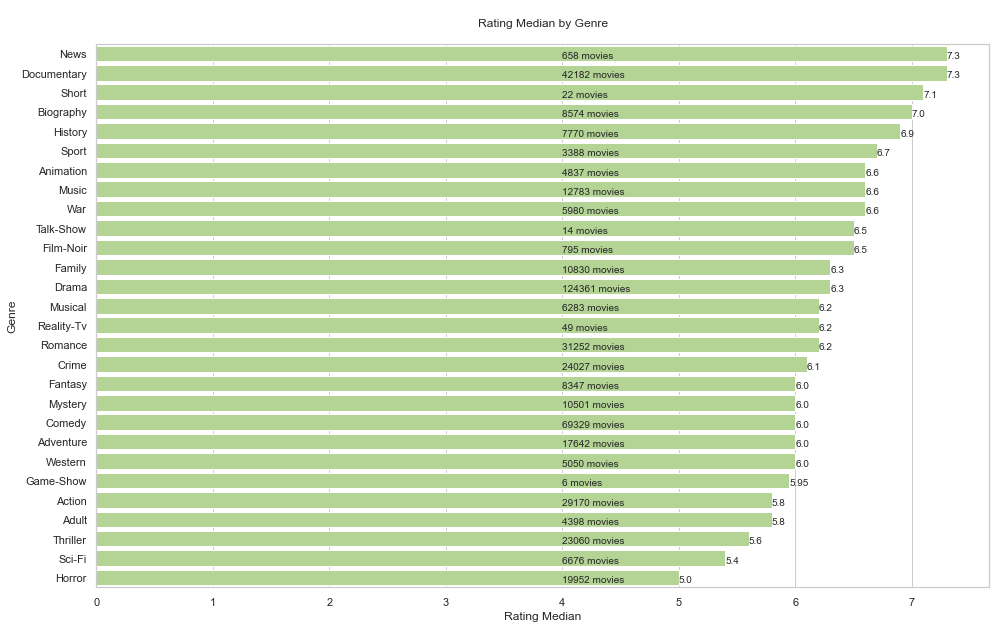

In [37]:
# Plot
# cs = sns.color_palette("Set2")
# Figura
plt.figure(figsize = (16,10))

# Barplot
sns.barplot(y = df_genre_ratings.genres.str.title(), x = df_genre_ratings.rating, orient = "h", color = '#B2DF8A')

# Textos do gráfico
for i in range(len(df_genre_ratings.index)):
    
    plt.text(4.0, 
             i + 0.25, 
             str(df_genre_ratings['count'][df_genre_ratings.index[i]]) + " movies")
    
    plt.text(df_genre_ratings.rating[df_genre_ratings.index[i]],
             i + 0.25,
             round(df_genre_ratings["rating"][df_genre_ratings.index[i]],2))

plt.ylabel('Genre')             
plt.xlabel('Rating Median')
plt.title('\nRating Median by Genre\n')
plt.show()

In [38]:
df_genre_ratings_2 = df_genre_ratings.loc[df_genre_ratings['count'] >= 1000]

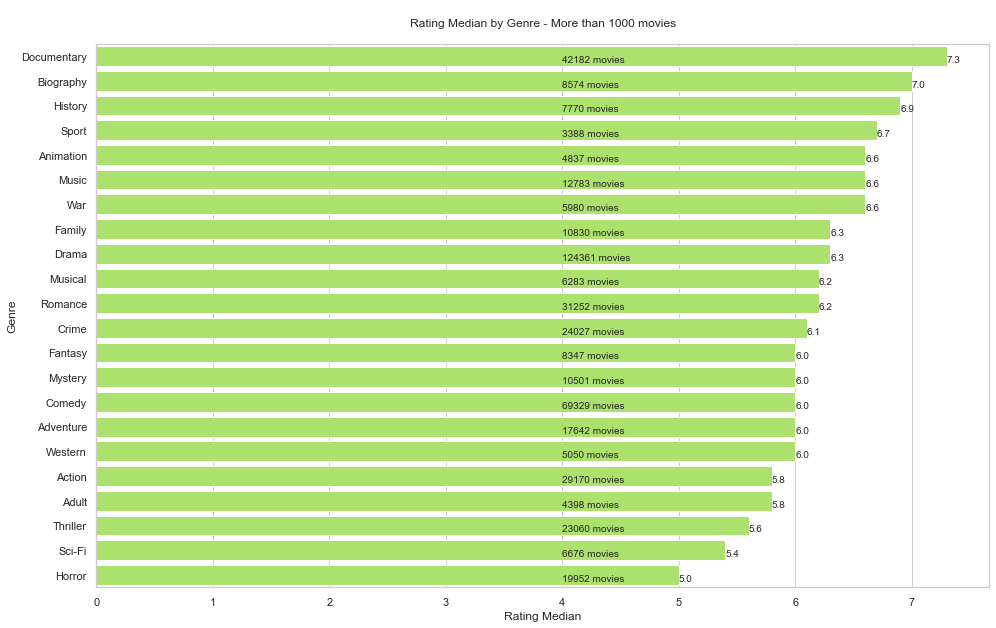

In [39]:
# Plot

# Figura
plt.figure(figsize = (16,10))

# Barplot
sns.barplot(y = df_genre_ratings_2.genres.str.title(), x = df_genre_ratings_2.rating, orient = "h", color = '#AFF45B')

# Textos do gráfico
for i in range(len(df_genre_ratings_2.index)):
    
    plt.text(4.0, 
             i + 0.25, 
             str(df_genre_ratings_2['count'][df_genre_ratings_2.index[i]]) + " movies")
    
    plt.text(df_genre_ratings_2.rating[df_genre_ratings_2.index[i]],
             i + 0.25,
             round(df_genre_ratings_2["rating"][df_genre_ratings_2.index[i]],2))

plt.ylabel('Genre')             
plt.xlabel('Rating Median')
plt.title('\nRating Median by Genre - More than 1000 movies\n')
plt.show()

___
4. What's the movie median rate by release year?
___

In [40]:
query4 = '''
            SELECT rating AS Rating, premiered 
            FROM ratings 
            JOIN titles ON ratings.title_id = titles.title_id 
            WHERE premiered <= 2022 AND type = 'movie'
            ORDER BY premiered
            ''' 

In [41]:
result4 = pd.read_sql_query(query4, conn)
display(result4)

,Rating,premiered
0,5.3,1894
1,6.7,1896
2,4.5,1897
3,4.0,1899
4,3.7,1899
...,...,...
280871,7.1,2022
280872,8.2,2022
280873,6.8,2022
280874,5.2,2022


In [42]:
ratings = []
for year in set(result4['premiered']):
    ratings.append(np.median(result4[result4['premiered'] == year]['Rating']))

years = list(set(result4['premiered']))

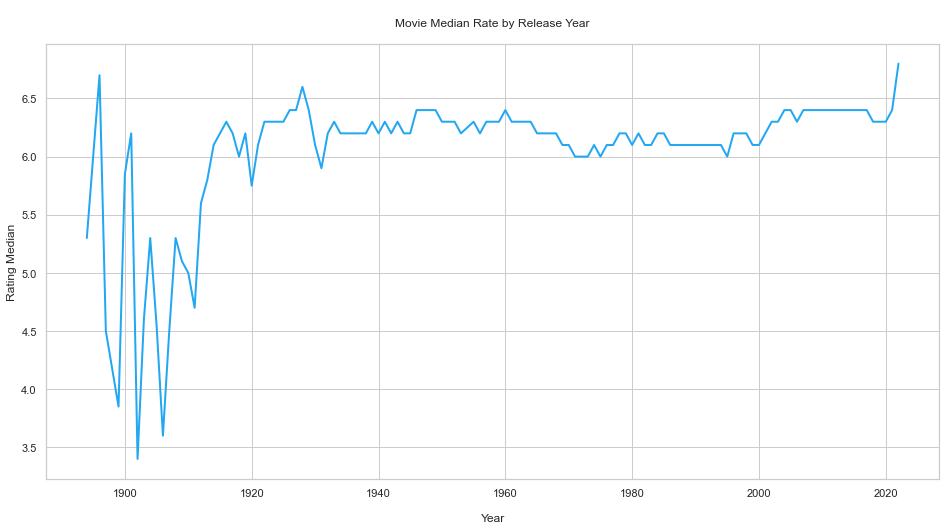

In [43]:
# Plot
plt.figure(figsize = (16,8))
plt.plot(years, ratings, color='#22A7F2', linewidth=2)
plt.xlabel('\nYear')
plt.ylabel('Rating Median')
plt.title("\nMovie Median Rate by Release Year\n")
plt.show()

____
5. What's the number of rated movies by genre and release year?
_____

In [44]:
unique_genre

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [45]:
genre_count = []
for item in unique_genre:
    query5 = 'SELECT COUNT(*) COUNT FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND premiered <= 2022'
    result5 = pd.read_sql_query(query5, conn)
    genre_count.append(result5['COUNT'].values[0])

In [46]:
df_genre_count = pd.DataFrame()
df_genre_count['genre'] = unique_genre
df_genre_count['Count'] = genre_count

In [47]:
df_genre_count = df_genre_count[df_genre_count['genre'] != 'n']
df_genre_count = df_genre_count.sort_values(by = 'Count', ascending = False)
top_genres = df_genre_count.head()['genre'].values

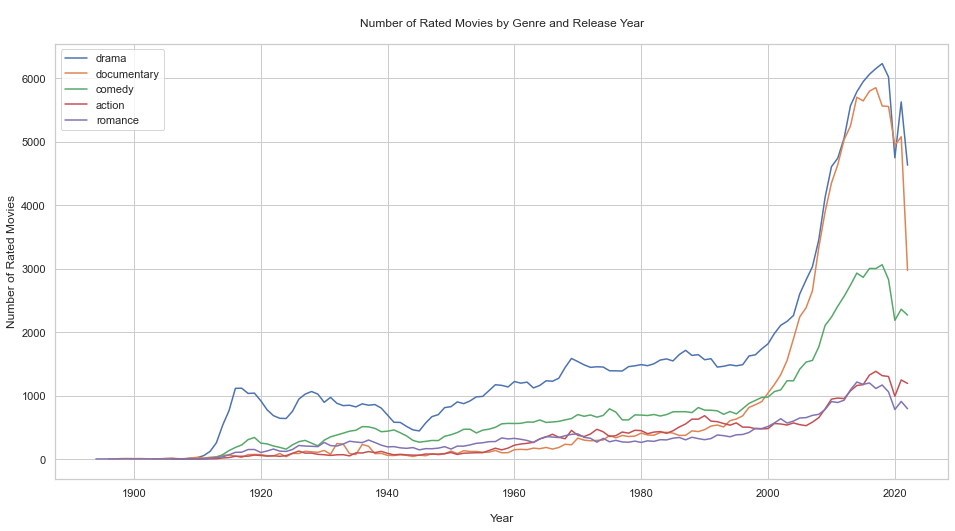

In [48]:
# Plot

plt.figure(figsize = (16,8))

for item in top_genres:
    query = 'SELECT COUNT(*) Number_of_movies, premiered Year FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND Year <=2022 GROUP BY Year'
    result = pd.read_sql_query(query, conn)
    plt.plot(result['Year'], result['Number_of_movies'])

plt.xlabel('\nYear')
plt.ylabel('Number of Rated Movies')
plt.title('\nNumber of Rated Movies by Genre and Release Year\n')
plt.legend(labels = top_genres)
plt.show()

____
6. Which is the longest movie? Calculate the percentiles
____

In [49]:
query6 = '''
            SELECT runtime_minutes Runtime 
            FROM titles 
            WHERE type = 'movie' AND Runtime != 'NaN'
        '''

In [50]:
result6 = pd.read_sql_query(query6, conn)
display(result6)

,Runtime
0,45
1,100
2,70
3,90
4,120
...,...
389900,123
389901,57
389902,100
389903,116


In [51]:
for i in range(101): 
    val = i
    perc = round(np.percentile(result6['Runtime'].values, val), 2)
    print('{} percentile of (runtime) is: {}'.format(val, perc))

0 percentile of (runtime) is: 1.0
1 percentile of (runtime) is: 45.0
2 percentile of (runtime) is: 47.0
3 percentile of (runtime) is: 50.0
4 percentile of (runtime) is: 50.0
5 percentile of (runtime) is: 51.0
6 percentile of (runtime) is: 52.0
7 percentile of (runtime) is: 53.0
8 percentile of (runtime) is: 55.0
9 percentile of (runtime) is: 56.0
10 percentile of (runtime) is: 57.0
11 percentile of (runtime) is: 58.0
12 percentile of (runtime) is: 60.0
13 percentile of (runtime) is: 60.0
14 percentile of (runtime) is: 60.0
15 percentile of (runtime) is: 61.0
16 percentile of (runtime) is: 62.0
17 percentile of (runtime) is: 64.0
18 percentile of (runtime) is: 65.0
19 percentile of (runtime) is: 67.0
20 percentile of (runtime) is: 69.0
21 percentile of (runtime) is: 70.0
22 percentile of (runtime) is: 70.0
23 percentile of (runtime) is: 71.0
24 percentile of (runtime) is: 72.0
25 percentile of (runtime) is: 73.0
26 percentile of (runtime) is: 74.0
27 percentile of (runtime) is: 75.0
28 

<AxesSubplot:>

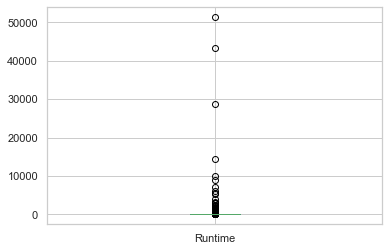

In [55]:
result6.plot(y = 'Runtime', kind = 'box')

In [56]:
query6 = '''
            SELECT runtime_minutes Runtime, primary_title
            FROM titles 
            WHERE type = 'movie' AND Runtime != 'NaN'
            ORDER BY Runtime DESC
            LIMIT 1
            ''' 

In [58]:
result6 = pd.read_sql_query(query6, conn)
display(result6)

,Runtime,primary_title
0,51420,Logistics


Logistics, or Logistics Art Project, is a 2012 Swedish experimental film conceived and created by Erika Magnusson and Daniel Andersson. At 51,420 minutes (857 hours or 35 days and 17 hours), it is the longest film ever made.

source: https://en.wikipedia.org/wiki


____
7. What's the number of movies produced by country?
___

In [61]:
query8 = '''
            SELECT region, COUNT(*) Number_of_movies FROM 
            akas JOIN titles ON 
            akas.title_id = titles.title_id
            WHERE region != 'None'
            AND type = \'movie\'
            GROUP BY region
            ''' 

In [107]:
result8 = pd.read_sql_query(query8, conn)
display(result8)

,region,Number_of_movies
0,AD,21
1,AE,6908
2,AF,114
3,AG,12
4,AL,1295
...,...,...
229,YUCS,153
230,ZA,7559
231,ZM,15
232,ZRCD,2


In [75]:
country_names = []
count = []
region =[]

for i in range(result8.shape[0]):
    try:
        coun = result8['region'].values[i]
        country_names.append(pycountry.countries.get(alpha_2 = coun).name)
        count.append(result8['Number_of_movies'].values[i])
        region.append(coun)
    except: 
        continue

In [113]:
df_movies_countries = pd.DataFrame()
df_movies_countries['Country'] = country_names
df_movies_countries['Movie_Count'] = count


In [114]:
df_movies_countries = df_movies_countries.sort_values(by = 'Movie_Count', ascending = False)
df_movies_countries.head(10)

,Country,Movie_Count
199,United States,315538
65,United Kingdom,160756
96,Japan,92733
63,France,85848
89,India,84763
32,Canada,80647
47,Germany,72182
58,Spain,66813
26,Brazil,66291
93,Italy,66264


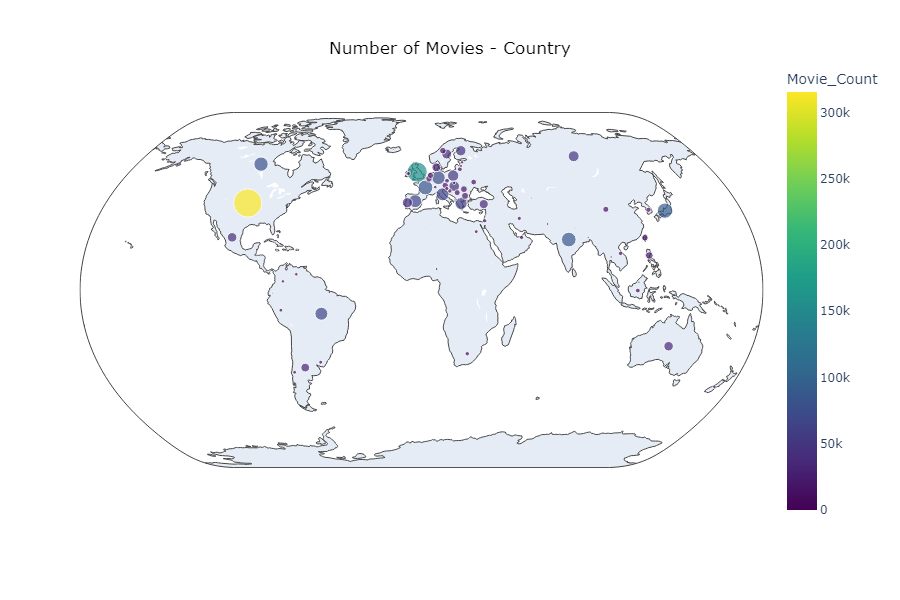

In [122]:
# df = px.data.gapminder()

fig = px.scatter_geo(df_movies_countries, locations="Country", locationmode='country names', color="Movie_Count",
                     hover_name="Country", size="Movie_Count",color_continuous_scale=px.colors.sequential.Viridis,
                     projection='natural earth', width=900, height=600)
fig.update_layout(
    title={
    'text': "Number of Movies - Country",
    'y':0.93,
    'x':0.5,
    'font_color': 'black'}
    )
fig.show("png")                    


____
8. Top 10 Best Movies - Considering ratings and more than 25000 votes
___

In [123]:
query8 = '''
            SELECT primary_title AS Movie_Name, genres, rating
            FROM 
            titles JOIN ratings
            ON  titles.title_id = ratings.title_id
            WHERE titles.type = 'movie' AND ratings.votes >= 25000
            ORDER BY rating DESC
            LIMIT 10          
            ''' 

In [125]:
top10_best_movies = pd.read_sql_query(query8, conn)
display(top10_best_movies)

,Movie_Name,genres,rating
0,The Shawshank Redemption,Drama,9.3
1,The Godfather,"Crime,Drama",9.2
2,The Chaos Class,"Comedy,Drama",9.2
3,CM101MMXI Fundamentals,"Comedy,Documentary",9.1
4,Rocketry: The Nambi Effect,"Biography,Drama",9.1
5,12 Angry Men,"Crime,Drama",9.0
6,The Godfather Part II,"Crime,Drama",9.0
7,Schindler's List,"Biography,Drama,History",9.0
8,The Lord of the Rings: The Return of the King,"Action,Adventure,Drama",9.0
9,The Dark Knight,"Action,Crime,Drama",9.0


___
9. Top 10 Worst Movies - Considering ratings and more than 25000 votes
___

In [126]:
query9 = '''
            SELECT primary_title AS Movie_Name, genres, rating
            FROM 
            titles JOIN ratings
            ON  titles.title_id = ratings.title_id
            WHERE titles.type = 'movie' AND ratings.votes >= 25000
            ORDER BY rating ASC
            LIMIT 10          
            ''' 

In [127]:
top10_worst_movies = pd.read_sql_query(query9, conn)
display(top10_worst_movies)

,Movie_Name,genres,rating
0,Reis,"Biography,Drama",1.0
1,Cumali Ceber,Comedy,1.0
2,Sadak 2,"Action,Drama",1.1
3,Smolensk,"Drama,Thriller",1.2
4,Superbabies: Baby Geniuses 2,"Comedy,Family,Sci-Fi",1.5
5,The Cost of Deception,"Crime,Drama,History",1.5
6,Manos: The Hands of Fate,Horror,1.6
7,Justin Bieber: Never Say Never,"Documentary,Music",1.6
8,From Justin to Kelly,"Comedy,Musical,Romance",1.9
9,The Hottie & the Nottie,"Comedy,Romance",1.9
